# LLM Tool Calling to ReAct Agent Tutorial

This tutorial progressively builds from basic LLM tool calling concepts to implementing a full ReAct agent.

## What we'll cover:
### Part 1
1. **Basic Tool Calling**: Understanding the fundamentals
2. **LangChain Integration**: Using LangChain for tool calling
### Part 2
3. **LangGraph Integration**: Building more complex workflows
4. **ReAct Agent**: Implementing a complete ReAct (Reasoning and Acting) agent

Let's start with the basics and work our way up!

## 1. Basic Tool Calling Fundamentals

Before diving into frameworks, let's understand the core concepts of tool calling with LLMs.

> uv install guide at https://docs.astral.sh/uv/guides/install-python/

In [ ]:
# Install required packages
# !pip install openai langchain langgraph langchain-openai

In [1]:
import json
import os
from openai import OpenAI
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
# Initialize OpenAI client
client = OpenAI()

### Step 1.1: Define a Simple Tool

Let's start with a basic calculator tool to understand the structure.

In [76]:
from typing import Union

def calculator(operation: str, a: float, b: float) -> Union[float, str]:
    """A simple calculator function"""
    if operation == "add":
        return a + b
    elif operation == "subtract":
        return a - b
    elif operation == "multiply":
        return a * b
    elif operation == "divide":
        if b != 0:
            return a / b
        else:
            return "Error: Division by zero"
    else:
        return "Error: Unsupported operation"

# Test the function
print(f"2 + 3 = {calculator('add', 2, 3)}")
print(f"10 / 2 = {calculator('divide', 10, 2)}")

2 + 3 = 5
10 / 2 = 5.0


### Step 1.2: Define Tool Schema for LLM

The LLM needs to understand what tools are available and how to use them. We define this using a schema.

In [77]:
# Tool schema that describes our calculator to the LLM
tool_schema = {
    "type": "function",
    "function": {
        "name": "calculator",
        "description": "Perform basic arithmetic operations (add, subtract, multiply, divide)",
        "parameters": {
            "type": "object",
            "properties": {
                "operation": {
                    "type": "string",
                    "enum": ["add", "subtract", "multiply", "divide"],
                    "description": "The arithmetic operation to perform"
                },
                "a": {
                    "type": "number",
                    "description": "The first number"
                },
                "b": {
                    "type": "number",
                    "description": "The second number"
                }
            },
            "required": ["operation", "a", "b"]
        }
    }
}

print("Tool schema defined:")
print(json.dumps(tool_schema, indent=2))

Tool schema defined:
{
  "type": "function",
  "function": {
    "name": "calculator",
    "description": "Perform basic arithmetic operations (add, subtract, multiply, divide)",
    "parameters": {
      "type": "object",
      "properties": {
        "operation": {
          "type": "string",
          "enum": [
            "add",
            "subtract",
            "multiply",
            "divide"
          ],
          "description": "The arithmetic operation to perform"
        },
        "a": {
          "type": "number",
          "description": "The first number"
        },
        "b": {
          "type": "number",
          "description": "The second number"
        }
      },
      "required": [
        "operation",
        "a",
        "b"
      ]
    }
  }
}


### Step 1.3: Basic Tool Calling with OpenAI

Now let's see how the LLM decides to call our tool.

In [78]:
def call_llm_with_tools(user_message: str):
    """Call LLM with tool calling capability"""
    
    # Send message to LLM with tool available
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",  # or use "gpt-4o-mini" for OpenAI's latest model
        messages=[
            {"role": "user", "content": user_message}
        ],
        tools=[tool_schema], # type: ignore
        tool_choice="required"  # Let the LLM decide whether to use tools
    )
    
    return response

# Test with a mathematical question
user_query = "What is 25 + 17?"
print(f"User: {user_query}\n")

response = call_llm_with_tools(user_query)
print("LLM Response:")
print(response.choices[0].message)

User: What is 25 + 17?

LLM Response:
ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_pdqNrXHJbbPac1N6zMEOTee3', function=Function(arguments='{"operation":"add","a":25,"b":17}', name='calculator'), type='function')])


### Step 1.4: Handle Tool Calls

When the LLM decides to use a tool, we need to execute it and send the results back.

In [7]:
def execute_tool_calls(response):
    """Execute tool calls from LLM response"""
    
    message = response.choices[0].message
    
    # Check if the LLM wants to call a tool
    if message.tool_calls:
        print("🔧 LLM decided to use a tool!")
        
        # Process each tool call
        for tool_call in message.tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)
            
            print(f"Tool: {function_name}")
            print(f"Arguments: {function_args}")
            
            # Execute our calculator function
            if function_name == "calculator":
                result = calculator(
                    function_args["operation"],
                    function_args["a"],
                    function_args["b"]
                )
                print(f"Result: {result}")
                return result
    else:
        print("📝 LLM responded without using tools:")
        print(message.content)
        return message.content

# Execute the tool call from our previous response
result = execute_tool_calls(response)
print(f"\n✅ Final Answer: {result}")

🔧 LLM decided to use a tool!
Tool: calculator
Arguments: {'operation': 'add', 'a': 25, 'b': 17}
Result: 42

✅ Final Answer: 42


### Step 1.5: Complete Tool Calling Flow

Let's put it all together in a complete function that handles the full flow.

In [ ]:
def complete_tool_calling_flow(user_message: str):
    """Complete flow: User message -> LLM -> Tool execution -> Final response"""
    
    print(f"👤 User: {user_message}\n")
    
    # Step 1: Send user message to LLM
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": user_message}],
        tools=[tool_schema],  # type: ignore
        tool_choice="auto"
    )
    
    message = response.choices[0].message
    
    # Step 2: Check if LLM wants to use tools
    if message.tool_calls:
        # Step 3: Execute tool calls
        tool_results = []
        for tool_call in message.tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)
            
            if function_name == "calculator":
                result = calculator(
                    function_args["operation"],
                    function_args["a"],
                    function_args["b"]
                )
                tool_results.append({
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": str(result)
                })
        
        # Step 4: Send tool results back to LLM for final response
        final_response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": user_message},
                message, # type: ignore
                *tool_results
            ]
        )
        
        final_answer = final_response.choices[0].message.content
        print(f"🤖 LLM Final Response: {final_answer}")
        
    else:
        print(f"🤖 LLM: {message.content}")

# Test the complete flow
complete_tool_calling_flow("Calculate 15 * 8 for me")
print("\n" + "="*50 + "\n")
complete_tool_calling_flow("What's the weather like?")  # Should not use calculator

👤 User: Calculate 15 * 8 for me

🤖 LLM: I need to use the calculator tool...

🔧 Calling calculator with {'operation': 'multiply', 'a': 15, 'b': 8}
📊 Tool result: 120

🤖 LLM: I need to use the calculator tool...

🔧 Calling calculator with {'operation': 'multiply', 'a': 15, 'b': 8}
📊 Tool result: 120

🤖 LLM Final Response: 15 * 8 equals 120.


👤 User: What's the weather like?

🤖 LLM Final Response: 15 * 8 equals 120.


👤 User: What's the weather like?

🤖 LLM: I'm not able to provide real-time weather updates. If you'd like, I can help you with some other requests or tasks. Just let me know how I can assist you today!
🤖 LLM: I'm not able to provide real-time weather updates. If you'd like, I can help you with some other requests or tasks. Just let me know how I can assist you today!


## 2. LangChain Integration

Now let's see how LangChain simplifies tool calling with its built-in abstractions.

> [LangChain Runnable](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.base.Runnable.html)

In [ ]:
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.agents import AgentExecutor, create_tool_calling_agent

### Step 2.1: Define Tools with LangChain Decorators

LangChain provides a simple `@tool` decorator to define tools.

In [11]:
@tool
def calculator_tool(operation: str, a: float, b: float) -> Union[float, str]:
    """Perform basic arithmetic operations (add, subtract, multiply, divide).
    
    Args:
        operation: The operation to perform (add, subtract, multiply, divide)
        a: First number
        b: Second number
    
    Returns:
        The result of the arithmetic operation
    """
    if operation == "add":
        return a + b
    elif operation == "subtract":
        return a - b
    elif operation == "multiply":
        return a * b
    elif operation == "divide":
        if b != 0:
            return a / b
        else:
            return "Error: Division by zero"
    else:
        return "Error: Unsupported operation"

@tool
def get_word_length(word: str) -> int:
    """Get the length of a word.
    
    Args:
        word: The word to count characters for
    
    Returns:
        Number of characters in the word
    """
    return len(word)

# Let's see what LangChain created for us
print("Calculator tool:")
print(f"Name: {calculator_tool.name}")
print(f"Description: {calculator_tool.description}")
print(f"Args schema: {calculator_tool.args}")

print("\nWord length tool:")
print(f"Name: {get_word_length.name}")
print(f"Description: {get_word_length.description}")

Calculator tool:
Name: calculator_tool
Description: Perform basic arithmetic operations (add, subtract, multiply, divide).

Args:
    operation: The operation to perform (add, subtract, multiply, divide)
    a: First number
    b: Second number

Returns:
    The result of the arithmetic operation
Args schema: {'operation': {'title': 'Operation', 'type': 'string'}, 'a': {'title': 'A', 'type': 'number'}, 'b': {'title': 'B', 'type': 'number'}}

Word length tool:
Name: get_word_length
Description: Get the length of a word.

Args:
    word: The word to count characters for

Returns:
    Number of characters in the word


### Step 2.2: Simple Tool Calling with LangChain

LangChain makes it much easier to bind tools to an LLM and handle the calling.

In [51]:
# Initialize LangChain LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Bind tools to the LLM
tools = [calculator_tool, get_word_length]
llm_with_tools = llm.bind_tools(tools)

# Simple usage
def simple_langchain_tool_call(user_message: str):
    print(f"👤 User: {user_message}")
    
    # Get LLM response
    response = llm_with_tools.invoke([HumanMessage(content=user_message)])
    
    print(f"🤖 LLM Response type: {type(response)}")
    print(f"🤖 Content: {response.content}")
    
    # Check for tool calls
    if response.tool_calls: # type: ignore
        print(f"🔧 Tool calls: {len(response.tool_calls)}") # type: ignore
        for tool_call in response.tool_calls: # type: ignore
            print(f"   - {tool_call['name']} with args: {tool_call['args']}")
    
    return response

# Test it
response1 = simple_langchain_tool_call("What is 20 divided by 4?")
print("\n" + "-"*40 + "\n")
response2 = simple_langchain_tool_call("How many letters are in the word 'LangChain'?")

👤 User: What is 20 divided by 4?
🤖 LLM Response type: <class 'langchain_core.messages.ai.AIMessage'>
🤖 Content: 
🔧 Tool calls: 1
   - calculator_tool with args: {'operation': 'divide', 'a': 20, 'b': 4}

----------------------------------------

👤 User: How many letters are in the word 'LangChain'?
🤖 LLM Response type: <class 'langchain_core.messages.ai.AIMessage'>
🤖 Content: 
🔧 Tool calls: 1
   - calculator_tool with args: {'operation': 'divide', 'a': 20, 'b': 4}

----------------------------------------

👤 User: How many letters are in the word 'LangChain'?
🤖 LLM Response type: <class 'langchain_core.messages.ai.AIMessage'>
🤖 Content: 
🔧 Tool calls: 1
   - get_word_length with args: {'word': 'LangChain'}
🤖 LLM Response type: <class 'langchain_core.messages.ai.AIMessage'>
🤖 Content: 
🔧 Tool calls: 1
   - get_word_length with args: {'word': 'LangChain'}


### Step 2.3: Tool Calling Agent with LangChain

LangChain provides pre-built agents that automatically handle the tool calling loop.

In [52]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Get a prompt template for tool calling agents
# Define a prompt template for the tool calling agent

# Create a prompt template similar to the one from the hub
system_template = "You are a helpful assistant that can use tools to answer the user's question."
system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

human_template = "{input}"
human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

prompt = ChatPromptTemplate.from_messages(
    [
        system_message_prompt,
        MessagesPlaceholder(variable_name="chat_history", optional=True),
        human_message_prompt,
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ]
)

# Initialize prompt with default empty chat history
prompt = prompt.partial(chat_history=[])



# Create the agent
agent = create_tool_calling_agent(llm, tools, prompt)

# Create an executor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# Test the agent
def test_langchain_agent(question: str):
    print(f"\n🔍 Testing: {question}")
    print("-" * 50)
    result = agent_executor.invoke({"input": question})
    print(f"\n✅ Final Answer: {result['output']}")
    return result

# Test with multiple operations
test_langchain_agent("Calculate 15 * 7, then tell me how many letters are in 'calculator'")


🔍 Testing: Calculate 15 * 7, then tell me how many letters are in 'calculator'
--------------------------------------------------


> Entering new AgentExecutor chain...

Invoking: `calculator_tool` with `{'operation': 'multiply', 'a': 15, 'b': 7}`


105.0
Invoking: `get_word_length` with `{'word': 'calculator'}`


10
Invoking: `calculator_tool` with `{'operation': 'multiply', 'a': 15, 'b': 7}`


105.0
Invoking: `get_word_length` with `{'word': 'calculator'}`


10The result of \( 15 \times 7 \) is \( 105 \), and the word "calculator" has \( 10 \) letters.

> Finished chain.

✅ Final Answer: The result of \( 15 \times 7 \) is \( 105 \), and the word "calculator" has \( 10 \) letters.
The result of \( 15 \times 7 \) is \( 105 \), and the word "calculator" has \( 10 \) letters.

> Finished chain.

✅ Final Answer: The result of \( 15 \times 7 \) is \( 105 \), and the word "calculator" has \( 10 \) letters.


{'input': "Calculate 15 * 7, then tell me how many letters are in 'calculator'",
 'output': 'The result of \\( 15 \\times 7 \\) is \\( 105 \\), and the word "calculator" has \\( 10 \\) letters.'}

## 3. LangGraph Integration

LangGraph allows us to create more complex, stateful workflows with better control over the agent's behavior.

In [53]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from typing import Annotated, Sequence
import operator

### Step 3.1: Define State and Create Graph

LangGraph uses state management to track conversation and tool usage.

In [54]:
# Define our state - LangGraph uses this to track conversation
class AgentState(MessagesState):
    # MessagesState already includes 'messages' field
    # We can add custom fields if needed
    pass

# Create the tools node
tool_node = ToolNode(tools)

# Define the agent node
def call_model(state: AgentState):
    print(f"🤖 Agent thinking... (processing {len(state['messages'])} messages)")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.set_entry_point("agent")

# Add conditional edges
workflow.add_conditional_edges(
    "agent",
    tools_condition,  # This decides whether to call tools or end
)

# Add edge from tools back to agent
workflow.add_edge("tools", "agent")

# Add memory for conversation state
memory = MemorySaver()

# Compile the graph
app = workflow.compile(checkpointer=memory)

print("✅ LangGraph workflow created successfully!")

✅ LangGraph workflow created successfully!


### Step 3.2: Visualize the Graph (Optional)

Let's see what our graph looks like.

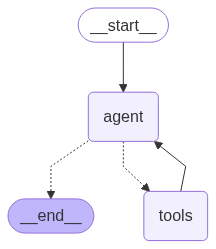

In [55]:
# Display the graph structure
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure:")
    print(app.get_graph().draw_ascii())

### Step 3.3: Run LangGraph Agent

Now let's test our LangGraph agent with stateful conversations.

In [56]:
def run_langgraph_agent(user_input: str, thread_id: str = "default"):
    print(f"👤 User: {user_input}")
    print("-" * 50)
    
    # Configure the thread for conversation memory
    config = {"configurable": {"thread_id": thread_id}}
    
    # Run the agent
    for event in app.stream(
        {"messages": [HumanMessage(content=user_input)]}, 
        config=config, # type: ignore
        stream_mode="values"
    ):
        # Print the latest message
        if "messages" in event and event["messages"]:
            latest_message = event["messages"][-1]
            if hasattr(latest_message, 'content') and latest_message.content:
                if isinstance(latest_message, AIMessage):
                    print(f"🤖 Agent: {latest_message.content}")
    
    print("\n" + "="*50 + "\n")

# Test the LangGraph agent
run_langgraph_agent("Calculate 12 * 8")
run_langgraph_agent("Now add 50 to that result", "default")  # Uses same thread
run_langgraph_agent("How many characters are in the word 'LangGraph'?", "default")

👤 User: Calculate 12 * 8
--------------------------------------------------
🤖 Agent thinking... (processing 1 messages)
🤖 Agent thinking... (processing 3 messages)
🤖 Agent thinking... (processing 3 messages)
🤖 Agent: The result of \( 12 \times 8 \) is \( 96 \).


👤 User: Now add 50 to that result
--------------------------------------------------
🤖 Agent thinking... (processing 5 messages)
🤖 Agent: The result of \( 12 \times 8 \) is \( 96 \).


👤 User: Now add 50 to that result
--------------------------------------------------
🤖 Agent thinking... (processing 5 messages)
🤖 Agent thinking... (processing 7 messages)
🤖 Agent thinking... (processing 7 messages)
🤖 Agent: The result of adding 50 to 96 is \( 146 \).


👤 User: How many characters are in the word 'LangGraph'?
--------------------------------------------------
🤖 Agent thinking... (processing 9 messages)
🤖 Agent: The result of adding 50 to 96 is \( 146 \).


👤 User: How many characters are in the word 'LangGraph'?
---------------

## 4. ReAct Agent Implementation

Now let's implement a full ReAct (Reasoning and Acting) agent that shows its thinking process.

### Step 4.1: Enhanced Tools for ReAct

Let's add more tools to make our ReAct agent more interesting.

In [ ]:
import datetime
import random

@tool
def get_current_time() -> str:
    """Get the current date and time.
    
    Returns:
        Current date and time as a string
    """
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
@tool
def text_analyzer(text: str) -> dict:
    """Analyze text and return various statistics.
    
    Args:
        text: The text to analyze
    
    Returns:
        Dictionary with text statistics
    """
    words = text.split()
    sentences = text.split('.') if '.' in text else [text]
    
    return {
        "character_count": len(text),
        "word_count": len(words),
        "sentence_count": len([s for s in sentences if s.strip()]),
        "average_word_length": sum(len(word) for word in words) / len(words) if words else 0
    }

@tool
def generate_random_number(min_value: int = 1, max_value: int = 100) -> int:
    """Generate a random number between min_value and max_value.
    
    Args:
        min_value: Minimum value (inclusive)
        max_value: Maximum value (inclusive)
    """
    return random.randint(min_value, max_value)

# Updated tools list
react_tools = [
    calculator_tool,
    get_word_length,
    get_current_time,
    generate_random_number,
    text_analyzer
]

print(f"✅ Created {len(react_tools)} tools for ReAct agent:")
for tool in react_tools:
    print(f"  - {tool.name}: {tool.description.split('.')[0]}")

✅ Created 5 tools for ReAct agent:
  - calculator_tool: Perform basic arithmetic operations (add, subtract, multiply, divide)
  - get_word_length: Get the length of a word
  - get_current_time: Get the current date and time
  - generate_random_number: Generate a random number within a specified range
  - text_analyzer: Analyze text and return various statistics


### Step 4.2: Custom ReAct Prompt

The key to ReAct is the prompt that encourages reasoning and action steps.

In [70]:

# Custom ReAct prompt template
react_prompt = """
You are a helpful assistant that can reason about problems and use tools to solve them.
"""

print("✅ ReAct prompt template created")

✅ ReAct prompt template created


### Step 4.3: ReAct Agent with LangGraph

Let's implement a ReAct agent using LangGraph that shows clear reasoning steps.

In [73]:
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import PromptTemplate

# Create ReAct prompt


# Create ReAct agent using LangGraph's implementation
react_agent = create_react_agent(model=llm, tools=react_tools, prompt=react_prompt, version="v2")

# Function to run the ReAct agent
def run_react_agent(question: str):
    print(f"🎯 Question: {question}")
    print("\n📝 ReAct Agent Reasoning Process:")
    print("=" * 60)
    
    # Stream the agent's thinking process to see step-by-step reasoning
    for chunk in react_agent.stream({"input": question}):
        if "actions" in chunk:
            for action in chunk["actions"]:
                print(f"🧠 Thought: {action.log}")
                print(f"🔧 Action: {action.tool}")
                print(f"📥 Input: {action.tool_input}")
                print("-" * 40)
        elif "output" in chunk:
            print(f"\n🎉 Final Answer: {chunk['output']}")
    
    print("=" * 60)
    
    # Return the final result
    result = react_agent.invoke({"input": question})
    return result

# Test with a complex multi-step problem
complex_question = """
I need you to:
1. Generate a random number between 10 and 50
2. Multiply that number by 3
3. Tell me what time it is
4. Analyze the text "The quick brown fox jumps over the lazy dog"
"""

run_react_agent(complex_question.strip())

🎯 Question: I need you to:
1. Generate a random number between 10 and 50
2. Multiply that number by 3
3. Tell me what time it is
4. Analyze the text "The quick brown fox jumps over the lazy dog"

📝 ReAct Agent Reasoning Process:


{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 363, 'total_tokens': 371, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bx3xIyfwWnr1Us7DHPgcrfy4YOD5X', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e212c491-65a0-4231-b9ee-1cde70a66d3b-0', usage_metadata={'input_tokens': 363, 'output_tokens': 8, 'total_tokens': 371, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## 🏁 Conclusion

Congratulations! You've learned how to:

1. **Understand tool calling fundamentals** - How LLMs decide when and how to use tools
2. **Implement basic tool calling** - Direct OpenAI API usage with manual handling
3. **Use LangChain for simplification** - Leverage frameworks for easier development
4. **Build complex workflows with LangGraph** - State management and visual workflows
5. **Create ReAct agents** - Reasoning and acting patterns for better problem-solving

### Next Steps:
- Try creating more complex tools (web search, file operations, API calls)
- Experiment with different prompting strategies
- Build domain-specific agents for your use cases
- Explore error handling and tool validation
- Look into tool composition and chaining

Happy building! 🚀